Fitting 3 folds for each of 48 candidates, totalling 144 fits


c:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


✅ Best Parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 400, 'subsample': 0.7}
✅ XGBoost Test RMSE: 42.62
✅ XGBoost Test R²: 0.731


c:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


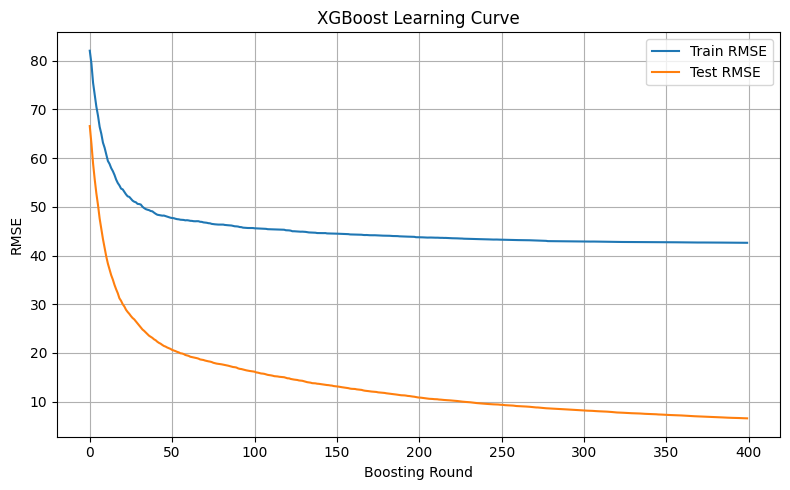

In [4]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# -------------------------------
# 1. 读取数据
# -------------------------------
df_model = pd.read_csv("london_model_with_poi.csv")

X = df_model.drop(columns=["Theft_Rate_per1k", "LSOA_Code"])
y = df_model["Theft_Rate_per1k"]
lsoa_code = df_model["LSOA_Code"].astype(str)

# -------------------------------
# 2. 划分训练集和测试集
# -------------------------------
X_train, X_test, y_train, y_test, lsoa_train, lsoa_test = train_test_split(
    X, y, lsoa_code, test_size=0.2, random_state=42
)

# -------------------------------
# 3. 构建 GridSearch + XGBoost 模型
# -------------------------------
xgb = XGBRegressor(objective='reg:squarederror', random_state=42)

param_grid = {
    'n_estimators': [200, 400],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.7, 0.8],
    'colsample_bytree': [0.7, 0.8]
}

grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error',
    cv=3,
    verbose=1,
    n_jobs=-1
)

# ✅ 使用 kwargs 正确传递 eval_set 参数
grid_search.fit(
    X_train, y_train,
    **{
        "eval_set": [(X_test, y_test),(X_train, y_train)],
        "early_stopping_rounds": 10,
        "eval_metric": "rmse",
        "verbose": False
    }
)

# -------------------------------
# 4. 获取最佳模型并重新训练
# -------------------------------
best_model = grid_search.best_estimator_

# 获取训练过程记录
eval_result = best_model.evals_result()


# -------------------------------
# 5. 模型评估
# -------------------------------
y_pred = best_model.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print("✅ Best Parameters:", grid_search.best_params_)
print(f"✅ XGBoost Test RMSE: {rmse:.2f}")
print(f"✅ XGBoost Test R²: {r2:.3f}")

# -------------------------------
# 6. 绘制学习曲线
# -------------------------------
train_errors = eval_result['validation_0']['rmse']
test_errors = eval_result['validation_1']['rmse']

plt.figure(figsize=(8, 5))
plt.plot(train_errors, label="Train RMSE")
plt.plot(test_errors, label="Test RMSE")
plt.xlabel("Boosting Round")
plt.ylabel("RMSE")
plt.title("XGBoost Learning Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [1]:
import xgboost
print(xgboost.__version__)  # 应该输出 1.7.6
from xgboost import XGBRegressor
print(type(XGBRegressor()))  # 应该是 <class 'xgboost.sklearn.XGBRegressor'>


1.7.6
<class 'xgboost.sklearn.XGBRegressor'>
